### Cts-Genome Coverage Plots

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, glob
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
dt = datetime.today().strftime(format='%d-%m-%Y')

In [3]:
#uniqueness in directory and file names is assumed for all analyses
sars_dir = "SARS-CoV-2"
home_dir = os.getenv('HOME')
parent_dir = glob.glob(f'{home_dir}/**/{sars_dir}', recursive=True)[0]

In [78]:
identifier = 'MinION-seq36' #NextSeq/MiSeq/MinION
df_cov = pd.read_excel(f'{parent_dir}/SeqReports/2022-03-01_run36_nanopore.Analysis.QCstats.xlsx', usecols=['sample_name', 'Genome fraction (%)'])

In [79]:
df_cov.head(1)

,sample_name,Genome fraction (%)
0,COVM02746,95.1


In [80]:
samp_names = list(df_cov['sample_name'])

In [81]:
df_Cts = pd.read_excel(f"{glob.glob(f'{parent_dir}/**/Outputs', recursive=True)[0]}/runsheet-cts.xlsx")[['Sample_Name', 'Well_Position', 'Ct_Mean', 'Dt_Run']]
# df_nhrl_Cts = pd.read_excel('/home/douso/Documents/RunSheets/Cts/NHRL-cts.xlsx')
# df_Cts = df_covc_Cts.append(df_nhrl_Cts)

In [82]:
df_ct_cov = (df_Cts.merge(df_cov, how='right', left_on='Sample_Name', 
            right_on='sample_name').drop('sample_name',axis=1).sort_values('Ct_Mean').fillna(0.0))#[df_Cts['Sample_Name'].isin(samp_names)]

In [83]:
df_ct_cov.head()

,Sample_Name,Well_Position,Ct_Mean,Dt_Run,Genome fraction (%)
0,COVM02746,C02,14.7,2022-02-28 19:24:39,95.1
13,COVM02766,D10,15.1,2022-02-28 19:24:39,91.5
10,COVM02728,A08,15.9,2022-02-28 19:24:39,92.5
2,COVM02727,A07,16.2,2022-02-28 19:24:39,94.2
14,COVM02737,B05,17.1,2022-02-28 19:24:39,91.5


In [84]:
# df_ct_cov.to_excel('/home/douso/Documents/RunSheets/Cts/cts-cov.xlsx', index=False, float_format='%.0f')

In [85]:
mask1 = df_ct_cov['Genome fraction (%)'] >= 80
mask2 = df_ct_cov['Ct_Mean'] > 30
mask3 = df_ct_cov['Ct_Mean'] <= 35
mask4 = df_ct_cov['Genome fraction (%)'] < 80
mask5 = df_ct_cov['Ct_Mean'] <= 30
mask6 = df_ct_cov['Ct_Mean'] > 35
# mask7 = df_ct_cov['G_COV'] > 80
# mask8 = df_ct_cov['G_COV'] < 80


above30below35_pass = df_ct_cov[mask1 & mask2 & mask3 == True].shape[0]
above30below35_fail = df_ct_cov[mask4 & mask2 & mask3 == True].shape[0]
below30above80_pass = df_ct_cov[mask5 & mask1 == True].shape[0]
below30below80_fail = df_ct_cov[mask5 & mask4 == True].shape[0]
above35above80_pass = df_ct_cov[mask6 & mask1 == True].shape[0]
above35below80_fail = df_ct_cov[mask6 & mask4 == True].shape[0]

print(below30above80_pass, below30below80_fail)
print(above35above80_pass, above35below80_fail)

24 3
0 2


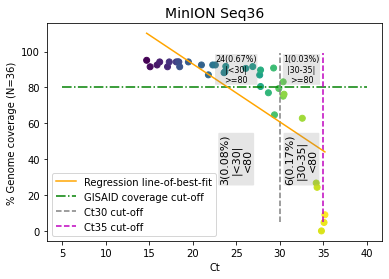

In [86]:
from scipy.interpolate import interp1d, make_interp_spline
fig,ax = plt.subplots()
lr = LinearRegression()
lr.fit(np.array(df_ct_cov['Ct_Mean']).reshape(-1, 1), df_ct_cov['Genome fraction (%)'])


y_predicted = lr.predict(np.array(df_ct_cov['Ct_Mean']).reshape(-1, 1))

# sns.regplot(x='Ct_Mean', y='Genome fraction (%)', order=2, ci=0, data=df_ct_cov)

# x_interp = np.linspace(df_ct_cov['Ct_Mean'].min(), df_ct_cov['Ct_Mean'].max(), len(df_ct_cov['Ct_Mean']))
# y_interp = df_ct_cov['Genome fraction (%)']
# bspline_interp = make_interp_spline(x_interp, y_interp, k=2)
# X_=np.linspace(x_interp.min(), x_interp.max(), 100)
# Y_=bspline_interp(X_)
N = len(df_ct_cov["Ct_Mean"])

plt.plot(df_ct_cov['Ct_Mean'], y_predicted, color='orange', label='Regression line-of-best-fit')

# plt.plot(X_, Y_, color='blue', label='Bspline line-of-best-fit')

plt.scatter(df_ct_cov['Ct_Mean'], df_ct_cov['Genome fraction (%)'], 
            c=np.linspace(0, 40, len(df_ct_cov['Ct_Mean'])), 
            cmap='viridis')#viridis#RdYlBu ,edgecolors='#FFF5EE'
# plt.colorbar(label='Cts', location='bottom')
ax.text(32.5, 90, s=f'{above30below35_pass}({round(above30below35_pass / N , 2)}%)\n|30-35|\n>=80', 
        ha="center", va="center", rotation=0, fontsize=8, 
        bbox=dict(boxstyle="round,pad=0.05", fc="gray", alpha=0.2, ec="b", lw=0))
ax.text(32.5, 40, s=f'{above30below35_fail}({round(above30below35_fail / N , 2)}%)\n|30-35|\n<80', 
        ha="center", va="center", rotation=90, fontsize=11, 
        bbox=dict(boxstyle="round,pad=0.1", fc="gray", alpha=0.2, ec="b", lw=0))
ax.text(25, 90, s=f'{below30above80_pass}({round(below30above80_pass / N , 2)}%)\n|<30|\n>=80', 
        ha="center", va="center", rotation=0, fontsize=8, 
        bbox=dict(boxstyle="round,pad=0.05", fc="gray", alpha=0.2, ec="b", lw=0))
ax.text(25, 40, s=f'{below30below80_fail}({round(below30below80_fail / N , 2)}%)\n|<30|\n<80', 
        ha="center", va="center", rotation=90, fontsize=11, 
        bbox=dict(boxstyle="round,pad=0.1", fc="gray", alpha=0.2, ec="b", lw=0))
plt.xlabel('Ct')
plt.ylabel(f'% Genome coverage (N={N})')
plt.hlines(80, 5, 40, linestyles='dashdot', colors='g', label='GISAID coverage cut-off')
plt.vlines(30, 5, 99, linestyles='dashed', colors='gray', label='Ct30 cut-off')
plt.vlines(35, 5, 99, linestyles='dashed', colors='m', label='Ct35 cut-off')
title = identifier.replace('-s', ' S')
plt.title(title, fontsize=14)
plt.legend()
# fig.savefig(f"{glob.glob(f'{parent_dir}/**/PlotsFigures', recursive=True)[0]}/{identifier}-CTs-report_{dt}.svg")
plt.show()

In [134]:
df_cov33 = pd.read_excel(f'{parent_dir}/SeqReports/output_2022-01-19-run33_nextseq.Analysis.QCstats.xlsx', usecols=['sample_name', 'Genome fraction (%)'])['Genome fraction (%)']
df_cov34 = pd.read_excel(f'{parent_dir}/SeqReports/output_2022-01-24_run34_nextseq.Analysis.QCstats.xlsx', usecols=['sample_name', 'Genome fraction (%)'])['Genome fraction (%)']
df_cov36 = pd.read_excel(f'{parent_dir}/SeqReports/2022-03-01_run36_nanopore.Analysis.QCstats.xlsx', usecols=['sample_name', 'Genome fraction (%)'])['Genome fraction (%)']
df_cov37 = pd.read_excel(f'{parent_dir}/SeqReports/2022-03-11_run37_miseq.Analysis.QCstats.xlsx', usecols=['sample_name', 'Genome fraction (%)'])['Genome fraction (%)']
df_cov38 = pd.read_excel(f'{parent_dir}/SeqReports/2022-03-20_run38_miseq.Analysis.QCstats.xlsx', usecols=['sample_name', 'Genome fraction (%)'])['Genome fraction (%)'].fillna(0.0)

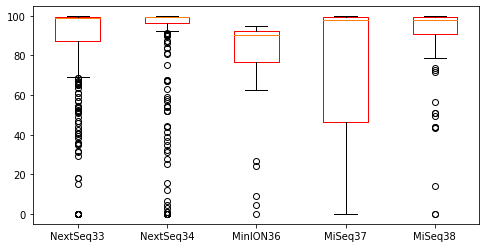

In [161]:
fig, ax = plt.subplots(figsize=(8,4))
plt.boxplot([df_cov33, df_cov34, df_cov36, df_cov37, df_cov38], whis=1.5, 
            labels=['NextSeq33', 'NextSeq34', 'MinION36', 'MiSeq37', 'MiSeq38'], boxprops={'color':'r'})
# fig.savefig(f"{glob.glob(f'{parent_dir}/**/PlotsFigures', recursive=True)[0]}/CTs-boxplot-report_{dt}.svg")
plt.show()

In [165]:
df.std()
df.mean().mean()

83.6300873655914

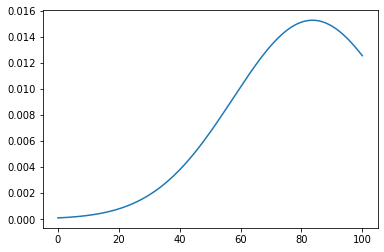

In [168]:
from scipy import stats
x = np.linspace(0, 100, 500)
pdf = stats.norm.pdf(x, 83.63, 26.12)
plt.plot(x, pdf)

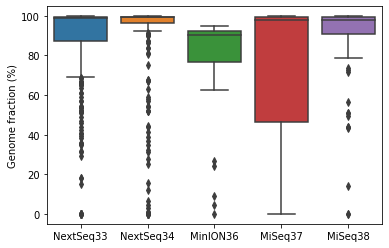

In [167]:
fig, ax = plt.subplots()
df = pd.DataFrame({'NextSeq33': df_cov33, 'NextSeq34': df_cov34, 'MinION36': df_cov36, 'MiSeq37':df_cov37, 'MiSeq38':df_cov38})
sns.boxplot(data=df)
#             color=['b', 'orange', 'green', 'yellow'])
plt.ylabel('Genome fraction (%)')
# fig.savefig(f"{glob.glob(f'{parent_dir}/**/PlotsFigures', recursive=True)[0]}/CTs-boxplot-report_{dt}.svg")
plt.show()